# Census API Example A
Hard code variables, build a url, retrieve data, perform basic pandas operations, retrieve variable metadata.

Example uses Population Estimates 2018 Vintage:
https://www.census.gov/data/developers/data-sets/popest-popproj/popest.Vintage_2018.html

Find ANSI / FIPS codes for geographies:
* Census Bureau: https://www.census.gov/library/reference/code-lists/ansi.html
* MCDC: https://census.missouri.edu/geocodes/

## Set Variables and Retrieve Data

In [1]:
%matplotlib inline
import requests, pandas as pd

In [2]:
#Set variables
year='2018'
dsource='pep'
dname='components'
cols='GEONAME,NATURALINC,DOMESTICMIG,INTERNATIONALMIG'
state='36'
county='005,047,061,081,085'

In [3]:
base_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}'
base_url

'https://api.census.gov/data/2018/pep/components'

In [4]:
data_url = f'{base_url}?get={cols}&for=county:{county}&in=state:{state}'
data_url

'https://api.census.gov/data/2018/pep/components?get=GEONAME,NATURALINC,DOMESTICMIG,INTERNATIONALMIG&for=county:005,047,061,081,085&in=state:36'

In [5]:
#Retrieve Data
response=requests.get(data_url)
print(response.text)

[["GEONAME","NATURALINC","DOMESTICMIG","INTERNATIONALMIG","state","county"],
["Bronx County, New York","12051","-16304","13346","36","005"],
["Kings County, New York","26189","-34171","15814","36","047"],
["New York County, New York","8083","-14389","12159","36","061"],
["Queens County, New York","15810","-26359","17912","36","081"],
["Richmond County, New York","1539","-1967","898","36","085"]]


In [6]:
#Save response as json object
data=response.json()
data

[['GEONAME',
  'NATURALINC',
  'DOMESTICMIG',
  'INTERNATIONALMIG',
  'state',
  'county'],
 ['Bronx County, New York', '12051', '-16304', '13346', '36', '005'],
 ['Kings County, New York', '26189', '-34171', '15814', '36', '047'],
 ['New York County, New York', '8083', '-14389', '12159', '36', '061'],
 ['Queens County, New York', '15810', '-26359', '17912', '36', '081'],
 ['Richmond County, New York', '1539', '-1967', '898', '36', '085']]

## Pandas Examples

In [7]:
#Convert to dataframe, perform some basic operations
df=pd.DataFrame(data[1:], columns=data[0]).\
rename(columns={"NATURALINC": "Natural Increase", "DOMESTICMIG": "Net Domestic Mig", "INTERNATIONALMIG":"Net Foreign Mig"})
df['fips']=df.state+df.county
df.set_index('fips',inplace=True)
df.drop(columns=['state','county'],inplace=True)
df=df.astype(dtype={'Natural Increase':'int64','Net Domestic Mig':'int64','Net Foreign Mig':'int64'})
df

,GEONAME,Natural Increase,Net Domestic Mig,Net Foreign Mig
fips,,,,
36005,"Bronx County, New York",12051,-16304,13346
36047,"Kings County, New York",26189,-34171,15814
36061,"New York County, New York",8083,-14389,12159
36081,"Queens County, New York",15810,-26359,17912
36085,"Richmond County, New York",1539,-1967,898


In [8]:
#Total population change 2017-2018
df.sum(axis=1)

fips
36005    9093
36047    7832
36061    5853
36081    7363
36085     470
dtype: int64

Text(0.5,0,'')

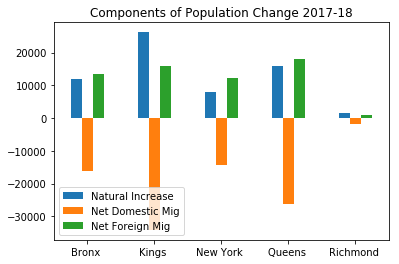

In [9]:
#Create a basic chart
labels=df['GEONAME'].str.split(',',expand=True)[0].str.replace('County','')
ax=df.plot.bar(rot=0, title='Components of Population Change 2017-18')
ax.set_xticklabels(labels)
ax.set_xlabel('')

## Obtain List of Variables

In [10]:
vars_url=f'https://api.census.gov/data/{year}/{dsource}/{dname}/variables.json'
response=requests.get(vars_url)

#"variables" is top key in the file - reference it to flatten the file so individual variables become keys 
variables=response.json()['variables']
variables

{'for': {'label': "Census API FIPS 'for' clause",
  'concept': 'Census API Geography Specification',
  'predicateType': 'fips-for',
  'group': 'N/A',
  'limit': 0,
  'predicateOnly': True},
 'in': {'label': "Census API FIPS 'in' clause",
  'concept': 'Census API Geography Specification',
  'predicateType': 'fips-in',
  'group': 'N/A',
  'limit': 0,
  'predicateOnly': True},
 'ucgid': {'label': 'Uniform Census Geography Identifier clause',
  'concept': 'Census API Geography Specification',
  'predicateType': 'ucgid',
  'group': 'N/A',
  'limit': 0,
  'predicateOnly': True},
 'NETMIG': {'label': 'Net migration in period',
  'predicateType': 'int',
  'group': 'N/A',
  'limit': 0},
 'SUMLEV': {'label': 'Summary Level',
  'predicateType': 'string',
  'group': 'N/A',
  'limit': 0},
 'RDEATH': {'label': 'Death rate in period',
  'predicateType': 'int',
  'group': 'N/A',
  'limit': 0},
 'STATE': {'label': 'State FIPS code', 'group': 'N/A', 'limit': 0},
 'DEATHS': {'label': 'Deaths in period',


In [11]:
#Iterate through keys and get specific sub-values
for k,v in variables.items():
    print(k,v['label'])

for Census API FIPS 'for' clause
in Census API FIPS 'in' clause
ucgid Uniform Census Geography Identifier clause
NETMIG Net migration in period
SUMLEV Summary Level
RDEATH Death rate in period
STATE State FIPS code
DEATHS Deaths in period
RDOMESTICMIG Net domestic migration rate in period
DIVISION Census Division Code
CSA Combined Statistical Area code
LASTUPDATE Last Update
NATION Nation
PERIOD_DESC Description of PERIOD values
RNATURALINC Natural increase rate in period
DOMESTICMIG Net domestic migration in period
UNIVERSE Universe
BIRTHS Births in period
COUNTY County FIPS code
MDIV Metropolitan Division code
GEONAME Geographic Name
RNETMIG Net migration rate in period
REGION Census Regional Code
NATURALINC Natural increase in period
GEO_ID Geographic identifier code
RESIDUAL Residual for period
INTERNATIONALMIG Net international migration in period
CBSA Metropolitan Statistical Area/Micropolitan Statistical Area code
RINTERNATIONALMIG Net international migration rate in period
RBIR

In [12]:
#Iterate even further to capture specific code lists
regions=variables['DIVISION']['values']['item']
regions

{'9': 'Pacific',
 '8': 'Mountain',
 '7': 'West South Central',
 '6': 'East South Central',
 '5': 'South Atlantic',
 '4': 'West North Central',
 '3': 'East North Central',
 '2': 'Middle Atlantic',
 '1': 'New England'}